In [3]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [59]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.io import arff
import xgboost as xgb
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics

In [5]:
df = pd.read_csv("students-all.csv")

In [6]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()
df_dummies = df_dummies.iloc[:,1:]
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0


In [60]:
def train_fast(df, max_depth, target ):
    
    # shuffling index
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    
    # 5 fold cross validation
    kf = KFold(n_splits=5)
        
    
    ret = []
    
    # we will make test 10% and validation 10%
    for train_index, test_index in kf.split(df):
        
        train = df.iloc[train_index,:]
        
        v_ind = test_index[0:(len(test_index)//2)] 
        t_ind = test_index[(len(test_index)//2):len(test_index)]
        
        validation = df.iloc[v_ind,:]
        test = df.iloc[t_ind,:]
        
        label_train = train[target]
        label_val = validation[target]
        label_test = test[target]

        df_train = train.drop([target], axis = 1)
        df_test  = test.drop([target], axis = 1)
        df_val  = validation.drop([target], axis = 1)
        
        dtrain = xgb.DMatrix(data = df_train, label=label_train)
        dval = xgb.DMatrix(data = df_val, label=label_val)
        dtest = xgb.DMatrix(data = df_test, label=label_val)
        
        param = {'max_depth': max_depth, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        
        num_round = 100
        
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=50)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

        fpr, tpr, thresholds = metrics.roc_curve(label_test.to_numpy(), y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        
        ret.append(metrics.auc(fpr, tpr))
    
    # plot figure - probably unnecessary here
    lw = 2
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

    plt.show()

    return np.array(ret).mean(), bst

[0]	eval-auc:0.70132	train-auc:0.93319
[50]	eval-auc:0.81959	train-auc:1.00000
[99]	eval-auc:0.81843	train-auc:1.00000
[0]	eval-auc:0.64277	train-auc:0.92504
[50]	eval-auc:0.82680	train-auc:1.00000
[99]	eval-auc:0.82394	train-auc:1.00000
[0]	eval-auc:0.62612	train-auc:0.92815
[50]	eval-auc:0.84294	train-auc:1.00000
[99]	eval-auc:0.83867	train-auc:1.00000
[0]	eval-auc:0.64951	train-auc:0.94181
[50]	eval-auc:0.80923	train-auc:1.00000
[99]	eval-auc:0.80024	train-auc:1.00000
[0]	eval-auc:0.64895	train-auc:0.91992
[50]	eval-auc:0.83403	train-auc:1.00000
[99]	eval-auc:0.85000	train-auc:1.00000


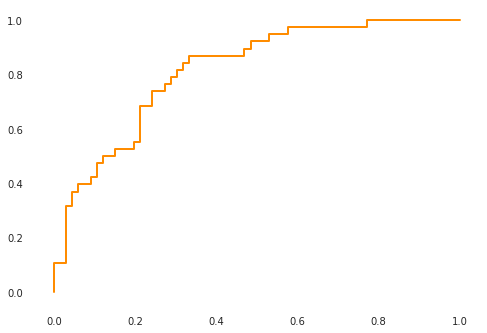

(0.8076676397007532, <xgboost.core.Booster at 0x7f9ebd8d3d50>)

In [63]:
train_fast(df_dummies, 13, "romantic_yes")

In [24]:
acc_results = []
acc_sum = 0
for i in range(10): 
    acc , bst = train_fast(df_dummies, 13, "romantic_yes")
    acc_sum += acc
acc_results.append(acc_sum/10)
acc_sum = 0

[0]	eval-auc:0.57743	train-auc:0.92682
[50]	eval-auc:0.75919	train-auc:1.00000
[99]	eval-auc:0.77236	train-auc:1.00000
[0]	eval-auc:0.73610	train-auc:0.92640
[50]	eval-auc:0.83787	train-auc:1.00000


/home/jakwisn/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[99]	eval-auc:0.83747	train-auc:1.00000
[0]	eval-auc:0.60580	train-auc:0.93720
[50]	eval-auc:0.82026	train-auc:1.00000
[99]	eval-auc:0.83946	train-auc:1.00000
[0]	eval-auc:0.74327	train-auc:0.92910
[50]	eval-auc:0.91059	train-auc:1.00000
[99]	eval-auc:0.89410	train-auc:1.00000
[0]	eval-auc:0.63221	train-auc:0.92231
[50]	eval-auc:0.81378	train-auc:1.00000
[99]	eval-auc:0.81339	train-auc:1.00000


TypeError: unsupported operand type(s) for +=: 'int' and 'list'

In [22]:
# Zróbmy średnią kroczącą 
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [23]:
a = moving_average(np.array(acc_results),5)

In [24]:
res = pd.DataFrame({"acc":a,"depth":np.arange(len(acc_results))[2:-2]})

Text(0.5, 1.0, 'moving average of accuracy, base = 3')

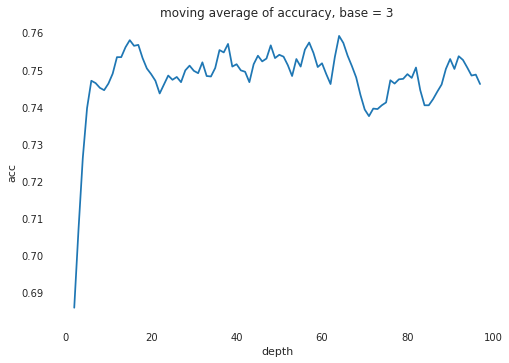

In [25]:
sns.lineplot(data = res, x = "depth", y = "acc").set_title("moving average of accuracy, base = 5")

In [42]:
def get_acc_mean(df):
    acc_sum = 0
    for i in range(20):
        acc , bst = train_fast(df, 18)
        acc_sum += acc
    return(acc_sum/20)

In [17]:
import category_encoders as ce

encolums = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'major_por']

In [43]:
%%capture
res_dict = {}
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BackwardDifferenceEncoder"] = get_acc_mean(df_encoded)

In [44]:
%%capture
encoder = ce.binary.BinaryEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BinaryEncoder"] = get_acc_mean(df_encoded)

In [45]:
%%capture
encoder = ce.basen.BaseNEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BaseNEncoder"] = get_acc_mean(df_encoded)

In [46]:
%%capture
encoder = ce.hashing.HashingEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["HashingEncoder"] = get_acc_mean(df_encoded)

In [47]:
%%capture
encoder = ce.helmert.HelmertEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["HelmertEncoder"] = get_acc_mean(df_encoded)

In [52]:
%%capture
encoder = ce.one_hot.OneHotEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["OneHotEncoder"] = get_acc_mean(df_encoded)

In [53]:
%%capture
encoder = ce.ordinal.OrdinalEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["OrdinalEncoder"] = get_acc_mean(df_encoded)

In [55]:
%%capture
encoder = ce.polynomial.PolynomialEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["PolynomialEncoder"] = get_acc_mean(df_encoded)

In [56]:
%%capture
encoder = ce.sum_coding.SumEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["SumEncoder"] = get_acc_mean(df_encoded)

In [57]:
from pprint import pprint
pprint(res_dict)

{'BackwardDifferenceEncoder': 0.743312101910828,
 'BaseNEncoder': 0.7420382165605096,
 'BinaryEncoder': 0.743312101910828,
 'HelmertEncoder': 0.7535031847133757,
 'OneHotEncoder': 0.7719745222929936,
 'OrdinalEncoder': 0.7426751592356687,
 'PolynomialEncoder': 0.7515923566878981,
 'SumEncoder': 0.7585987261146496,
 'hashing.HashingEncoder(': 0.6404458598726113}


Widzimy, że najlepiej wypada model dla głębokości około 40, ale ogólnie charakteryzuje się sporą wariancją wyniku accuracy

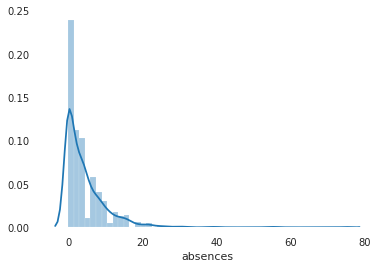

In [123]:
sns.distplot(df.absences)

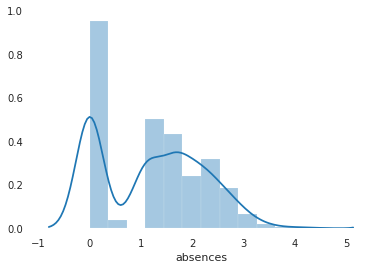

In [124]:
sns.distplot(np.log(df.absences+1)) # pytanie czy warto, może coś lepszego

In [220]:
df["absences"] = np.log(df.absences +1)

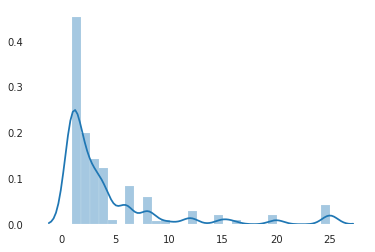

In [158]:
sns.distplot(df.loc[df.romantic_yes == 1].Walc * df.loc[df.romantic_yes == 1].Dalc)

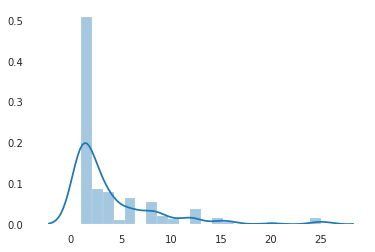

In [159]:
sns.distplot(df.loc[df.romantic_yes == 0].Walc * df.loc[df.romantic_yes == 0].Dalc)

In [221]:
df["WeekandEnd"] = df.Walc * df.Dalc

In [222]:
acc_arr = np.zeros(20)
for i in range(20):
    acc2, _ = train_fast(df,40)
    acc_arr[i] = acc2

[0]	eval-auc:0.69847	train-auc:0.943899
[50]	eval-auc:0.769577	train-auc:1
[99]	eval-auc:0.762196	train-auc:1
[0]	eval-auc:0.655798	train-auc:0.934646
[50]	eval-auc:0.821396	train-auc:1
[99]	eval-auc:0.8366	train-auc:1
[0]	eval-auc:0.678363	train-auc:0.949497
[50]	eval-auc:0.795676	train-auc:1
[99]	eval-auc:0.793727	train-auc:1
[0]	eval-auc:0.535996	train-auc:0.915929
[50]	eval-auc:0.762777	train-auc:1
[99]	eval-auc:0.775966	train-auc:1
[0]	eval-auc:0.671387	train-auc:0.930621
[50]	eval-auc:0.845497	train-auc:1
[99]	eval-auc:0.837691	train-auc:1
[0]	eval-auc:0.744374	train-auc:0.945999
[50]	eval-auc:0.863193	train-auc:1
[99]	eval-auc:0.846004	train-auc:1
[0]	eval-auc:0.662301	train-auc:0.934734
[50]	eval-auc:0.823228	train-auc:1
[99]	eval-auc:0.831288	train-auc:1
[0]	eval-auc:0.622592	train-auc:0.921328
[50]	eval-auc:0.805581	train-auc:1
[99]	eval-auc:0.80216	train-auc:1
[0]	eval-auc:0.611786	train-auc:0.94098
[50]	eval-auc:0.810571	train-auc:1
[99]	eval-auc:0.808063	train-auc:1
[0]	ev

In [223]:
acc_arr.mean()       # ciut lepiej

0.7535031847133759

In [224]:
a = np.where((df.Dalc > 3)&(df.Walc <3),1,0 )   # wniosek z eda, osoby oznaczone w tej kolumnie jako 1, to wyłącznie romantycy
df["WeirdDrinker"] = a

In [225]:
acc_arr = np.zeros(20)
for i in range(20):
    acc3, _ = train_fast(df,40)
    acc_arr[i] = acc3

[0]	eval-auc:0.647882	train-auc:0.93077
[50]	eval-auc:0.742867	train-auc:1
[99]	eval-auc:0.761652	train-auc:1
[0]	eval-auc:0.651935	train-auc:0.952581
[50]	eval-auc:0.776598	train-auc:1
[99]	eval-auc:0.774437	train-auc:1
[0]	eval-auc:0.687144	train-auc:0.931398
[50]	eval-auc:0.837619	train-auc:1
[99]	eval-auc:0.839517	train-auc:1
[0]	eval-auc:0.701292	train-auc:0.947721
[50]	eval-auc:0.851659	train-auc:1
[99]	eval-auc:0.850116	train-auc:1
[0]	eval-auc:0.573943	train-auc:0.90367
[50]	eval-auc:0.747541	train-auc:1
[99]	eval-auc:0.748922	train-auc:1
[0]	eval-auc:0.608726	train-auc:0.935896
[50]	eval-auc:0.776566	train-auc:1
[99]	eval-auc:0.780084	train-auc:1
[0]	eval-auc:0.661058	train-auc:0.915763
[50]	eval-auc:0.768491	train-auc:1
[99]	eval-auc:0.780695	train-auc:1
[0]	eval-auc:0.605421	train-auc:0.927021
[50]	eval-auc:0.840085	train-auc:1
[99]	eval-auc:0.837963	train-auc:1
[0]	eval-auc:0.600734	train-auc:0.94493
[50]	eval-auc:0.816355	train-auc:1
[99]	eval-auc:0.802726	train-auc:1
[0]	

In [226]:
acc_arr.mean()      # już dużo lepiej niż oryginalnie

0.771656050955414

In [203]:
from sklearn.decomposition import PCA

In [185]:
pca = PCA(n_components=10) 
principalComponents = pca.fit_transform(df.drop("romantic_yes", axis = 1))

cols = []
for i in range(10): 
    cols.append("pc"+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,9.353774,-0.550099,-0.110924,1.886126,2.526790,1.923906,-1.242351,-0.024718,0.037111,0.616042
1,10.094487,-1.389813,-2.389793,-0.335878,1.051091,-0.025940,-1.065988,-0.697437,0.053942,0.416029
2,4.957534,0.323846,-2.723654,-0.444309,1.689641,-1.447474,1.149817,-0.858096,-0.621435,-0.693584
3,-6.021629,-1.902445,1.577135,-1.106217,0.872031,-0.140397,1.308566,-0.877959,-0.555090,0.681144
4,4.019292,-0.189450,-0.932625,-1.010804,3.890214,0.445719,0.270783,1.191066,-0.959605,0.038107
...,...,...,...,...,...,...,...,...,...,...
1039,1.678819,-0.104869,-0.122668,-1.480298,-0.138726,2.519995,-0.997655,0.763093,-0.258722,-0.676246
1040,-7.072694,-0.597366,-1.782231,1.796408,-1.610812,0.667217,-1.030189,-0.487840,-0.032344,0.276993
1041,1.331891,-2.302947,-1.179159,-2.085767,-1.457850,1.768753,3.105314,0.654245,-2.098445,0.207371
1042,2.377861,2.692444,-0.893670,1.841289,-1.186198,-1.044776,0.687772,-0.241463,-0.489388,-0.457325


In [187]:
pca.explained_variance_ratio_.cumsum()   # 65 % wariancji w 2 ważnych kolumnach

array([0.59902194, 0.65019026, 0.69491414, 0.73266921, 0.77016296,
       0.79725053, 0.82188999, 0.84136708, 0.8570918 , 0.87190621])

zredukowaliśmy wymiar do 10

In [188]:
pca_df = pd.concat([principalDf,df.romantic_yes],axis =1)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,romantic_yes
0,9.353774,-0.550099,-0.110924,1.886126,2.526790,1.923906,-1.242351,-0.024718,0.037111,0.616042,0
1,10.094487,-1.389813,-2.389793,-0.335878,1.051091,-0.025940,-1.065988,-0.697437,0.053942,0.416029,0
2,4.957534,0.323846,-2.723654,-0.444309,1.689641,-1.447474,1.149817,-0.858096,-0.621435,-0.693584,0
3,-6.021629,-1.902445,1.577135,-1.106217,0.872031,-0.140397,1.308566,-0.877959,-0.555090,0.681144,1
4,4.019292,-0.189450,-0.932625,-1.010804,3.890214,0.445719,0.270783,1.191066,-0.959605,0.038107,0
...,...,...,...,...,...,...,...,...,...,...,...
1039,1.678819,-0.104869,-0.122668,-1.480298,-0.138726,2.519995,-0.997655,0.763093,-0.258722,-0.676246,0
1040,-7.072694,-0.597366,-1.782231,1.796408,-1.610812,0.667217,-1.030189,-0.487840,-0.032344,0.276993,0
1041,1.331891,-2.302947,-1.179159,-2.085767,-1.457850,1.768753,3.105314,0.654245,-2.098445,0.207371,0
1042,2.377861,2.692444,-0.893670,1.841289,-1.186198,-1.044776,0.687772,-0.241463,-0.489388,-0.457325,0


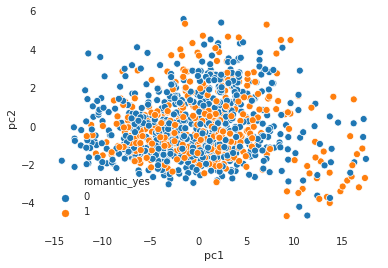

In [189]:
sns.scatterplot(x = "pc1", y = "pc2", data = pca_df, hue = "romantic_yes")  

Nie widać widocznego podziału danych

In [198]:
acc_arr = np.zeros(20)
for i in range(20):
    acc4, _ =  train_fast(pca_df,40)
    acc_arr[i] = acc3             

[0]	eval-auc:0.590414	train-auc:0.938522
[50]	eval-auc:0.66594	train-auc:1
[99]	eval-auc:0.651961	train-auc:1


/home/jakwisn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jakwisn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-auc:0.564772	train-auc:0.947271
[50]	eval-auc:0.615975	train-auc:1
[99]	eval-auc:0.617512	train-auc:1
[0]	eval-auc:0.54392	train-auc:0.937361
[50]	eval-auc:0.641421	train-auc:1
[99]	eval-auc:0.656451	train-auc:1
[0]	eval-auc:0.534023	train-auc:0.942584
[50]	eval-auc:0.655626	train-auc:1
[99]	eval-auc:0.656166	train-auc:1
[0]	eval-auc:0.57507	train-auc:0.936163
[50]	eval-auc:0.627638	train-auc:1
[99]	eval-auc:0.619421	train-auc:1
[0]	eval-auc:0.551198	train-auc:0.929449
[50]	eval-auc:0.686093	train-auc:1
[99]	eval-auc:0.687545	train-auc:1
[0]	eval-auc:0.649788	train-auc:0.950377
[50]	eval-auc:0.678819	train-auc:1
[99]	eval-auc:0.689236	train-auc:1
[0]	eval-auc:0.588125	train-auc:0.915627
[50]	eval-auc:0.601607	train-auc:1
[99]	eval-auc:0.590893	train-auc:1
[0]	eval-auc:0.59386	train-auc:0.931298
[50]	eval-auc:0.698276	train-auc:1
[99]	eval-auc:0.695989	train-auc:1
[0]	eval-auc:0.503754	train-auc:0.953026
[50]	eval-auc:0.611404	train-auc:1
[99]	eval-auc:0.627435	train-auc:1
[0]	

In [200]:
acc_arr.mean()                                  # jest okej, ale lepiej gdy działamy na zwykłych danych

0.7388535031847134

In [227]:
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por,WeekandEnd,WeirdDrinker
0,18,4,4,2,2,0,4,3,4,1,1,3,1.945910,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,1.609438,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
2,15,1,1,1,2,3,4,3,2,2,3,3,2.397895,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,6,0
3,15,4,2,1,3,0,3,2,2,1,1,5,1.098612,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,1.609438,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,2,0


Czyli najlepsze, bo ok 77% dostaliśmy accuracy modelu z kilkoma dodatkowymi kolumnami. Co jeszcze warto przemyśleć? Standaryzację zmiennych, jaki ma efekt dla modelu (dla tego powinien mieć żaden), na koniec projektu przemyślimy kilka modeli - drzewiaste, sieć nauronową oraz być może k średich. 